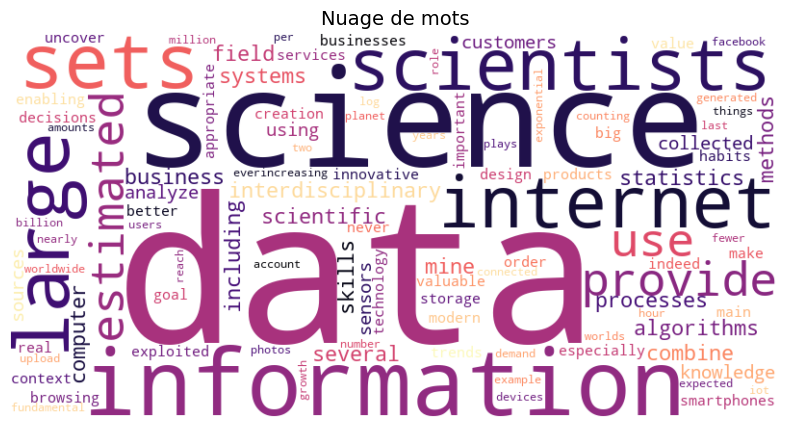

In [1]:
import tkinter as tk
from tkinter import messagebox, filedialog
from collections import Counter
import string
from textblob import Blobber
from textblob_fr import PatternTagger, PatternAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer
from heapq import nlargest
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from langdetect import detect
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
from reportlab.lib.pagesizes import A4
from tkinter import messagebox
from reportlab.pdfgen import canvas

# 🧽 Fonction de nettoyage et d'analyse/controle de saisie
def analyser_texte():
    texte = text_entry.get("1.0", tk.END).strip()
    if not texte:
        messagebox.showerror("Erreur", "Veuillez entrer un texte.")
        return

    # Détection de langue
    try:
        langue_detectee = detect(texte)
        if langue_detectee != 'fr':
            messagebox.showwarning("Langue détectée", f"⚠️ Le texte semble être en {langue_detectee.upper()}, pas en français.")
    except:
        messagebox.showerror("Erreur", "Impossible de détecter la langue.")
        return

    texte_clean = texte.lower().translate(str.maketrans('', '', string.punctuation))
    stopwords_fr = set([
        "le", "la", "les", "de", "des", "du", "et", "en", "un", "une", "dans",
        "ce", "cette", "il", "elle", "on", "pour", "par", "est", "a", "au", "aux",
        "sur", "avec", "plus", "pas", "ne", "que", "qui", "nous", "vous", "se",
        "sont", "mais", "où", "encore"
    ])
    mots = texte_clean.split()
    mots_filtrés = [mot for mot in mots if mot not in stopwords_fr and mot.isalpha()]
    frequence = Counter(mots_filtrés)
    frequence_str = "\n".join([f"{mot} : {freq}" for mot, freq in frequence.most_common(10)])

    # Statistiques de base
    nb_mots = len(mots)
    nb_phrases = len(texte.split('.'))

    # Résumé
    nb_res = int(nb_spinbox.get())
    resume = resume_texte(texte, nb_phrases=nb_res)

    # Sentiment -blobber:analyser et traiter le texte
    tb = Blobber(pos_tagger=PatternTagger(),#étiqueter les mots en fonction de leur catégorie grammaticale
                 analyzer=PatternAnalyzer())#un analyseur de sentiment basé sur des règles de patterns 
    blob = tb(texte)
    sentiment = f"Polarité : {blob.sentiment[0]:.2f}   (de -1 à 1)\nSubjectivité : {blob.sentiment[1]:.2f}   (de 0 à 1)"

    # Wordcloud
    wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='magma').generate(" ".join(mots_filtrés))

    # Affichage
    result_text.delete(1.0, tk.END)
    result_text.insert(tk.END, f"📊 Statistiques :\nMots : {nb_mots} | Phrases : {nb_phrases}\n\n")
    result_text.insert(tk.END, f"🔢 Mots les plus fréquents :\n{frequence_str}\n\n")
    result_text.insert(tk.END, f"📝 Résumé ({nb_res} phrases) :\n{resume}\n\n")
    result_text.insert(tk.END, f"📈 Analyse de sentiment :\n{sentiment}\n\n")

    # Affichage nuage de mots
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title("Nuage de mots", fontsize=14)
    plt.show()


# 🧠 Résumé intelligent
def resume_texte(texte, nb_phrases=3):

    phrases = [phrase.strip() for phrase in texte.split('.') if phrase.strip()]
    if len(phrases) <= nb_phrases:
        return '. '.join(phrases) + '.'

    stopwords_fr = set([
        "le", "la", "les", "de", "des", "du", "et", "en", "un", "une", "dans",
        "ce", "cette", "il", "elle", "on", "pour", "par", "est", "a", "au", "aux",
        "sur", "avec", "plus", "pas", "ne", "que", "qui", "nous", "vous", "se",
        "sont", "mais", "où", "encore"
    ])
    #transformer en vecteurs pour voir l'importance des phrases par rapport le texte
    tfidf = TfidfVectorizer(stop_words=list(stopwords_fr))
    tfidf_matrix = tfidf.fit_transform(phrases)
    #calcul de similarité
    texte_vector = np.asarray(tfidf_matrix.sum(axis=0)).reshape(1, -1)
    phrase_scores = cosine_similarity(tfidf_matrix, texte_vector)
    scores = phrase_scores.flatten()#transformer une matrice en un vecteur à une seule dimension
    indices_meilleures = np.argsort(scores)[-nb_phrases:]#tri des meilleurs phrases trouvées
    indices_meilleures.sort()
    #Création du résumé avec meilleurs phrases trouvées
    meilleures_phrases = [phrases[i] for i in indices_meilleures]
    return '. '.join(meilleures_phrases) + '.'


# 📂 Chargement de fichier
def charger_fichier():
    fichier = filedialog.askopenfilename(filetypes=[("Fichiers texte", "*.txt")])
    if fichier:
        with open(fichier, "r", encoding="utf-8") as f:
            contenu = f.read()
            text_entry.delete("1.0", tk.END)
            text_entry.insert(tk.END, contenu)


# 💾 Exportation


def exporter_resultats():
    try:
        contenu = result_text.get("1.0", tk.END).strip()
        if not contenu:
            messagebox.showwarning("Exportation", "Aucun texte à exporter.")
            return
        
        c = canvas.Canvas("analyse_resultat.pdf", pagesize=A4)
        largeur, hauteur = A4
        lignes = contenu.split('\n')
        y = hauteur - 50  # Position de départ sur la page

        for ligne in lignes:
            if y < 50:  # Saut de page si plus de place
                c.showPage()
                y = hauteur - 50
            c.drawString(50, y, ligne)
            y -= 15  # Espacement entre lignes

        c.save()
        messagebox.showinfo("Exportation", "Résultats exportés avec succès dans 'analyse_resultat.pdf'")
    except Exception as e:
        messagebox.showerror("Erreur", f"Une erreur est survenue : {e}")


# 🎨 Interface graphique
root = tk.Tk()
root.title("🧠 Analyseur de Texte Intelligent")
root.geometry("850x750")  # Taille de la fenêtre plus grande

# Ajouter un fond coloré pour la fenêtre
root.config(bg="#f4f4f9")

# Zone de texte
label = tk.Label(root, text="Entrez votre texte :", font=("Arial", 14, "bold"), bg="#f4f4f9")
label.pack(pady=10)
text_entry = tk.Text(root, height=10, width=70, font=("Arial", 12), wrap=tk.WORD, bd=2, relief="solid", padx=10, pady=10)
text_entry.pack(pady=10)

# Paramètres
param_frame = tk.Frame(root, bg="#f4f4f9")
param_frame.pack()

tk.Label(param_frame, text="🧩 Nombre de phrases pour le résumé :", font=("Arial", 12), bg="#f4f4f9").grid(row=0, column=0, padx=10, pady=10)
nb_spinbox = tk.Spinbox(param_frame, from_=1, to=10, width=5, font=("Arial", 12), bd=2)
nb_spinbox.grid(row=0, column=1, padx=10, pady=10)

# Boutons avec une meilleure présentation
btn_frame = tk.Frame(root, bg="#f4f4f9")
btn_frame.pack(pady=20)

tk.Button(btn_frame, text="📂 Charger un fichier", command=charger_fichier, font=("Arial", 12), bg="#4CAF50", fg="white", bd=2, relief="raised", width=20).grid(row=0, column=0, padx=10)
tk.Button(btn_frame, text="📊 Analyser", command=analyser_texte, font=("Arial", 12), bg="#2196F3", fg="white", bd=2, relief="raised", width=20).grid(row=0, column=1, padx=10)
tk.Button(btn_frame, text="💾 Exporter les résultats", command=exporter_resultats, font=("Arial", 12), bg="#FFC107", fg="white", bd=2, relief="raised", width=20).grid(row=0, column=2, padx=10)

# Résultats
result_text = tk.Text(root, height=20, width=80, font=("Arial", 11), wrap=tk.WORD, bd=2, relief="solid", padx=10, pady=10)
result_text.pack(pady=10)

# Lancement
root.mainloop()
